## Assignment 5 - CS5500
***Taha Adeel Mohammed - CS20BTECH1105***

In [26]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import torch
import torch.nn as nn
import pandas
from collections import namedtuple
import random
import gym
from tqdm.notebook import tqdm

In [27]:
np.random.seed(0) # Set seeds for reproducibility
torch.manual_seed(0)
random.seed(0)

try:
    import mplcyberpunk
    plt.style.use('cyberpunk')
except: 
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available
print(f'Using device: {device}')

Using device: cuda


### Problem 1: Deep Deterministic Policy Gradients

#### (a) Loading the environments

In [28]:
mountain_env = gym.make('MountainCarContinuous-v0')

# Print action and state space dimensions
print(f'State space dimension: {mountain_env.observation_space.shape[0]}')
print(f'Action space dimension: {mountain_env.action_space.shape[0]}\n')

# Print action and state space
print(f'State space: {mountain_env.observation_space}')
print(f'Action space: {mountain_env.action_space}')

State space dimension: 2
Action space dimension: 1

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)


In [29]:
lunar_env = gym.make('LunarLanderContinuous-v2')

# Print action and state space dimensions
print(f'State space dimension: {lunar_env.observation_space.shape[0]}')
print(f'Action space dimension: {lunar_env.action_space.shape[0]}\n')

# Print action and state space
print(f'State space: {lunar_env.observation_space}')
print(f'Action space: {lunar_env.action_space}')

State space dimension: 8
Action space dimension: 2

State space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)


In [30]:
class RandomAgent:
    '''Random Agent to understand the reward function of the environment'''
    def __init__(self, env: gym.Env):
        self.env = env
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.total_reward = 0
        self.num_steps = 0
        
    def step(self):
        '''Take a random action'''
        action = self.action_space.sample()
        state, reward, terminated, _, _ = self.env.step(action)
        self.total_reward += reward
        self.num_steps += 1
        return state, reward, terminated
    
    def reset(self):
        '''Reset the environment'''
        self.total_reward = 0
        self.num_steps = 0
        return self.env.reset()
    
    def run(self, num_episodes=1, max_steps=1000, verbose=False):
        '''Run the agent in the environment for num_episodes'''
        for episode in range(num_episodes):
            state, _ = self.reset()
            terminated = False
            for step in range(max_steps):
                state, reward, terminated = self.step()
                if terminated:
                    break
            if verbose:
                print(f'Episode: {episode+1}: Terminated: {terminated}, Total Reward: {self.total_reward}, Total Steps: {self.num_steps}, Average Reward: {self.total_reward/self.num_steps}')

In [31]:
random_car_agent = RandomAgent(mountain_env)
random_car_agent.run(num_episodes=5, max_steps=1000, verbose=True)

Episode: 1: Terminated: False, Total Reward: -33.20090812774666, Total Steps: 1000, Average Reward: -0.033200908127746655
Episode: 2: Terminated: False, Total Reward: -32.873816518464864, Total Steps: 1000, Average Reward: -0.03287381651846486
Episode: 3: Terminated: False, Total Reward: -34.02023896864236, Total Steps: 1000, Average Reward: -0.03402023896864236
Episode: 4: Terminated: False, Total Reward: -32.152446220999174, Total Steps: 1000, Average Reward: -0.03215244622099917
Episode: 5: Terminated: False, Total Reward: -34.51733795370689, Total Steps: 1000, Average Reward: -0.03451733795370689


In [32]:
random_lander_agent = RandomAgent(lunar_env)
random_lander_agent.run(num_episodes=5, max_steps=200, verbose=True)

Episode: 1: Terminated: True, Total Reward: -70.79876769639452, Total Steps: 104, Average Reward: -0.6807573816961011
Episode: 2: Terminated: True, Total Reward: -365.4185061838104, Total Steps: 88, Average Reward: -4.152483024816028
Episode: 3: Terminated: True, Total Reward: -167.77041566603856, Total Steps: 107, Average Reward: -1.5679478099629771
Episode: 4: Terminated: True, Total Reward: -193.23736221272173, Total Steps: 77, Average Reward: -2.5095761326327497
Episode: 5: Terminated: True, Total Reward: -176.3904451589102, Total Steps: 95, Average Reward: -1.8567415279885284


#### (b) DDPG Algorithm

##### Exploration Noise Class

In [33]:
class OUActionNoise:
    ''' Ornstein-Uhlenbeck process that adds noise to actions for exploration '''
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=0.01):
        self.theta = theta # Rate of mean reversion
        self.mu = mu
        self.sigma = sigma
        self.dt = dt # Time step size
        self.reset()
        
    def reset(self):
        ''' Reset noise to mean '''
        self.noise = np.zeros_like(self.mu)
        
    def __call__(self):
        ''' Generate noise '''
        self.noise = self.noise + self.theta * (self.mu - self.noise) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        return self.noise

##### Replay Buffer Class

In [34]:
class ReplayBuffer:
    ''' Replay buffer to store and sample experiences '''
    def __init__(self, max_size):
        self.buffer = []
        self.memory_cnt = 0 # Counter for current position in buffer
        self.replay_size = max_size # Maximum size of buffer
        self.transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
        
    def add_experience(self, *experience):
        ''' Store experience to buffer '''
        if self.memory_cnt < self.replay_size:
            self.buffer.append(self.transition(*experience))
        else:
            self.buffer[self.memory_cnt % self.replay_size] = self.transition(*experience)
        self.memory_cnt += 1
        
    def sample(self, batch_size):
        ''' Returns a random sample of experiences from buffer '''
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        ''' Returns the current size of the buffer '''
        return len(self.buffer)

##### Actor-Critic Network Classes

In [35]:

class Actor(nn.Module):
    ''' Actor network that learns the policy function '''
    def __init__(self, states_dim, actions_dim, hidden1_dim=400, hidden2_dim=300):
        super(Actor, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(states_dim, hidden1_dim),
            nn.LayerNorm(hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim, hidden2_dim),
            nn.LayerNorm(hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim, actions_dim),
            nn.Tanh()
        )
        
        # Initialize weights and biases for better training (acc to paper)
        self.actor[0].weight.data.uniform_(-1/np.sqrt(states_dim), 1/np.sqrt(states_dim))
        self.actor[0].bias.data.uniform_(-1/np.sqrt(states_dim), 1/np.sqrt(states_dim))
        self.actor[3].weight.data.uniform_(-1/np.sqrt(hidden1_dim), 1/np.sqrt(hidden1_dim))
        self.actor[3].bias.data.uniform_(-1/np.sqrt(hidden1_dim), 1/np.sqrt(hidden1_dim))
        self.actor[6].weight.data.uniform_(-3e-3, 3e-3) # From paper
        self.actor[6].bias.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        ''' Returns action given state '''
        return self.actor(state)

In [36]:
class Critic(nn.Module):
    ''' Critic network that learns the state value and action value functions '''
    def __init__(self, states_dim, actions_dim, hidden1_dim=400, hidden2_dim=300):
        super(Critic, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(states_dim, hidden1_dim),
            nn.LayerNorm(hidden1_dim),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(actions_dim+hidden1_dim, hidden2_dim),
            nn.LayerNorm(hidden2_dim),
            nn.ReLU()
        )
        self.layer3 = nn.Linear(hidden2_dim, 1)
        
        # Initialize weights and biases
        self.layer1[0].weight.data.uniform_(-1/np.sqrt(states_dim), 1/np.sqrt(states_dim))
        self.layer1[0].bias.data.uniform_(-1/np.sqrt(states_dim), 1/np.sqrt(states_dim))
        self.layer2[0].weight.data.uniform_(-1/np.sqrt(actions_dim+hidden1_dim), 1/np.sqrt(actions_dim+hidden1_dim))
        self.layer2[0].bias.data.uniform_(-1/np.sqrt(actions_dim+hidden1_dim), 1/np.sqrt(actions_dim+hidden1_dim))
        self.layer3.weight.data.uniform_(-3e-3, 3e-3)
        self.layer3.bias.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        ''' Forward pass through network '''
        x = self.layer1(states)
        x = self.layer2(torch.cat([x, actions], dim=1))
        x = self.layer3(x)
        return x

##### DDPG Algorithm

In [37]:
class DDPGAgent:
    ''' Agent that interacts with and learns from the environment '''
    def __init__(self, env: gym.Env, noise, gamma=0.99, tau=0.01, buffer_size=int(1e6), batch_size=64):
        self.env = env
        self.gamma = gamma # Discount factor
        self.tau = tau # Soft update factor
        self.batch_size = batch_size
        self.noise = noise
        self.eval = False
        
        # Initialize actor and critic networks
        self.actor = Actor(self.env.observation_space.shape[0], self.env.action_space.shape[0]).to(device)
        self.target_actor = Actor(self.env.observation_space.shape[0], self.env.action_space.shape[0]).to(device)
        self.critic = Critic(self.env.observation_space.shape[0], self.env.action_space.shape[0]).to(device)
        self.target_critic = Critic(self.env.observation_space.shape[0], self.env.action_space.shape[0]).to(device)
        
        # Initialize target networks with same weights as original networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
            
        self.critic_loss = nn.MSELoss()
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4, weight_decay=1e-3)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.replay_buffer = ReplayBuffer(buffer_size)
        
    def soft_update(self, target, original):
        ''' Soft update target network parameters '''
        for target_param, original_param in zip(target.parameters(), original.parameters()):
            target_param.data.copy_(self.tau * original_param.data + (1.0 - self.tau) * target_param.data)
        
    def act(self, state):
        ''' Returns action given state '''
        state = torch.tensor(state.reshape(1, -1)).float().to(device)
        action = self.actor(state).cpu().data.numpy().flatten()
        if not self.eval:
            action = action + self.noise()
        return action
    
    def step(self, state, action, reward, next_state, done):
        ''' Add experience to replay buffer and learn from experiences '''
        self.replay_buffer.add_experience(state, action, reward, next_state, done)
        
        if len(self.replay_buffer) > self.batch_size:
            experiences = self.replay_buffer.sample(self.batch_size)
            self.learn(experiences)
            
    def learn(self, experiences):
        ''' Update actor and critic networks from experiences '''
        states = torch.tensor(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.tensor(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.tensor(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.tensor(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.tensor(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        # Update critic network
        next_actions = self.target_actor(next_states)
        target_critic = self.target_critic(next_states, next_actions)
        critic_target = rewards + (self.gamma * target_critic * (1 - dones))
        critic_expected = self.critic(states, actions)
        critic_loss = self.critic_loss(critic_expected, critic_target)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update actor network
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Soft update target networks
        self.soft_update(self.target_actor, self.actor)
        self.soft_update(self.target_critic, self.critic)
        
    def train(self, episodes, max_steps=1000, verbose=False):
        ''' Train agent in environment and save rewards '''
        self.episode_steps = np.zeros(episodes)
        self.episode_rewards = np.zeros(episodes)
        self.episode_critic_loss = np.zeros(episodes)
        self.episode_actor_loss = np.zeros(episodes)
        for episode in tqdm(range(episodes)):
            state, _ = self.env.reset()
            self.noise.reset()
            while True:
                action = self.act(state)
                next_state, reward, terminated, _, _ = self.env.step(action)
                self.episode_rewards[episode] += reward
                self.step(state, action, reward, next_state, terminated)
                state = next_state
                self.episode_steps[episode] += 1
                if terminated or self.episode_steps[episode] >= max_steps:
                    break
            if verbose:
                print(f'Episode {episode+1:<2} -> Total reward: {self.episode_rewards[episode]:<8.2f} | Total steps: {int(self.episode_steps[episode]):<5} | Average reward: {self.episode_rewards[episode]/self.episode_steps[episode]:<5.4f}')
                
    def plot(self):
        ''' Plot rewards and losses '''
        plt.figure(figsize=(16, 4))
        plt.suptitle('Learning Graphs', fontsize=16, fontweight='bold')
        
        plt.subplot(121)
        plt.title('Total Rewards')
        plt.plot(self.episode_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        
        plt.subplot(122)
        plt.title('Total Steps')
        plt.plot(self.episode_steps)
        plt.xlabel('Episodes')
        plt.ylabel('Steps')
        
        plt.show()

##### MountainCarContinuous-v0

In [38]:
exploration_noise = OUActionNoise(mu=np.zeros(1), sigma=0.4, theta=0.15, dt=0.01)

In [39]:
ddpg_car_agent = DDPGAgent(mountain_env, exploration_noise, batch_size=64)

In [40]:
ddpg_car_agent.train(episodes=50, max_steps=4000, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 1  -> Total reward: -255.05  | Total steps: 4000  | Average reward: -0.0638
Episode 2  -> Total reward: 22.01    | Total steps: 1955  | Average reward: 0.0113
Episode 3  -> Total reward: -348.07  | Total steps: 4000  | Average reward: -0.0870
Episode 4  -> Total reward: -863.40  | Total steps: 4000  | Average reward: -0.2159
Episode 5  -> Total reward: 74.83    | Total steps: 986   | Average reward: 0.0759
Episode 6  -> Total reward: 47.58    | Total steps: 1258  | Average reward: 0.0378
Episode 7  -> Total reward: 42.68    | Total steps: 393   | Average reward: 0.1086
Episode 8  -> Total reward: 85.31    | Total steps: 319   | Average reward: 0.2674
Episode 9  -> Total reward: 72.04    | Total steps: 878   | Average reward: 0.0821
Episode 10 -> Total reward: 88.35    | Total steps: 245   | Average reward: 0.3606
Episode 11 -> Total reward: 86.36    | Total steps: 264   | Average reward: 0.3271
Episode 12 -> Total reward: 83.74    | Total steps: 299   | Average reward: 0.2801
E

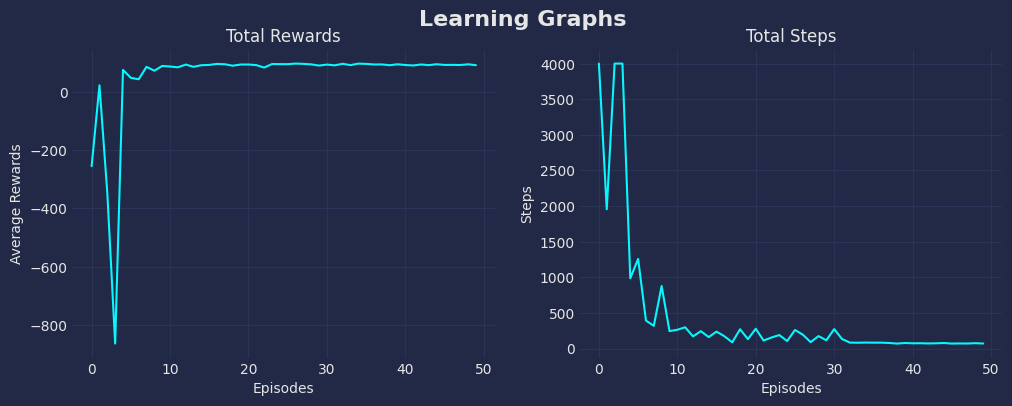

In [41]:
ddpg_car_agent.plot()

##### LunarLanderContinuous-v2

In [42]:
exploration_noise = OUActionNoise(mu=np.zeros(1), sigma=0.4, theta=0.15, dt=0.01)

In [43]:
ddpg_lander_agent = DDPGAgent(lunar_env, exploration_noise, batch_size=512)

In [44]:
ddpg_lander_agent.train(episodes=300, max_steps=2000, verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

Episode 1  -> Total reward: -107.76  | Total steps: 66    | Average reward: -1.6327
Episode 2  -> Total reward: -174.16  | Total steps: 80    | Average reward: -2.1770
Episode 3  -> Total reward: -262.89  | Total steps: 118   | Average reward: -2.2279
Episode 4  -> Total reward: -147.48  | Total steps: 63    | Average reward: -2.3410
Episode 5  -> Total reward: -129.58  | Total steps: 94    | Average reward: -1.3785
Episode 6  -> Total reward: -360.34  | Total steps: 126   | Average reward: -2.8598
Episode 7  -> Total reward: -623.96  | Total steps: 76    | Average reward: -8.2100
Episode 8  -> Total reward: -1315.51 | Total steps: 150   | Average reward: -8.7700
Episode 9  -> Total reward: -965.22  | Total steps: 84    | Average reward: -11.4907
Episode 10 -> Total reward: -703.16  | Total steps: 95    | Average reward: -7.4017
Episode 11 -> Total reward: -1513.82 | Total steps: 119   | Average reward: -12.7212
Episode 12 -> Total reward: -929.74  | Total steps: 89    | Average reward

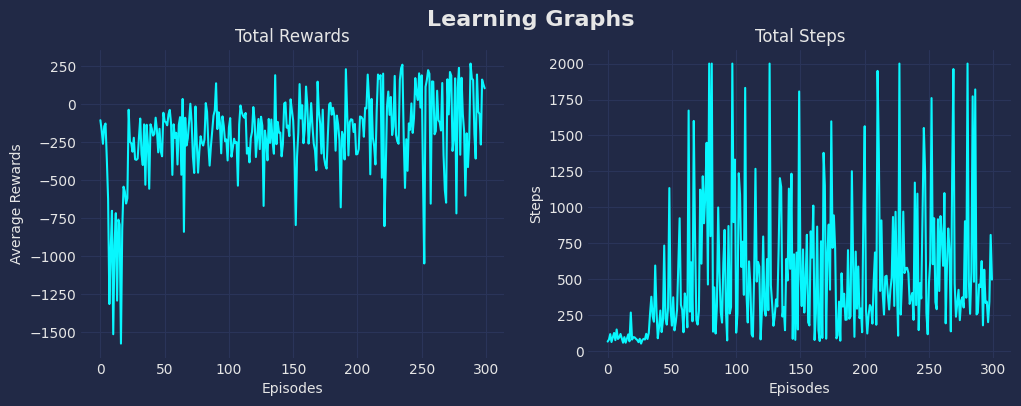

In [45]:
ddpg_lander_agent.plot()

#### (c) Gaussian Noise

In [46]:
class GaussianNoise:
    ''' Gaussian noise to add to actions for exploration '''
    def __init__(self, mu, sigma=0.15):
        self.mu = mu
        self.sigma = sigma
        
    def __call__(self):
        ''' Generate noise '''
        return np.random.normal(self.mu, self.sigma)

    def reset(self):
        pass
        
exploration_noise = GaussianNoise(mu=0, sigma=0.3)

#### MountainCarContinuous-v0

In [47]:
ddpg_car_agent_gaussian = DDPGAgent(mountain_env, exploration_noise, batch_size=64)

In [48]:
ddpg_car_agent_gaussian.train(episodes=50, max_steps=4000, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 1  -> Total reward: -50.98   | Total steps: 4000  | Average reward: -0.0127
Episode 2  -> Total reward: -37.43   | Total steps: 4000  | Average reward: -0.0094
Episode 3  -> Total reward: -39.03   | Total steps: 4000  | Average reward: -0.0098
Episode 4  -> Total reward: -36.70   | Total steps: 4000  | Average reward: -0.0092
Episode 5  -> Total reward: -35.09   | Total steps: 4000  | Average reward: -0.0088
Episode 6  -> Total reward: -36.90   | Total steps: 4000  | Average reward: -0.0092
Episode 7  -> Total reward: -37.01   | Total steps: 4000  | Average reward: -0.0093
Episode 8  -> Total reward: -35.20   | Total steps: 4000  | Average reward: -0.0088
Episode 9  -> Total reward: -36.25   | Total steps: 4000  | Average reward: -0.0091
Episode 10 -> Total reward: -35.06   | Total steps: 4000  | Average reward: -0.0088
Episode 11 -> Total reward: -35.37   | Total steps: 4000  | Average reward: -0.0088
Episode 12 -> Total reward: -36.37   | Total steps: 4000  | Average reward: 

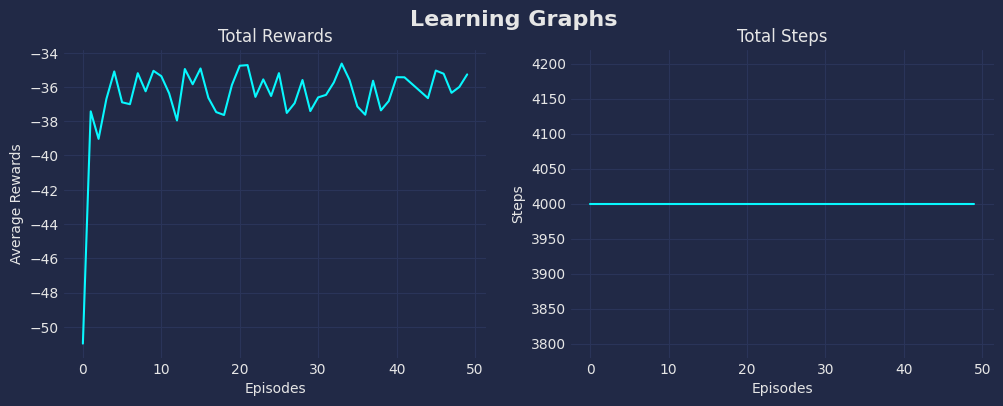

In [49]:
ddpg_car_agent_gaussian.plot()

#### LunarLanderContinuous-v2

In [50]:
ddpg_lander_agent_gaussian = DDPGAgent(lunar_env, exploration_noise, batch_size=64)

In [51]:
ddpg_lander_agent_gaussian.train(episodes=300, max_steps=1000, verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

Episode 1  -> Total reward: -120.00  | Total steps: 164   | Average reward: -0.7317
Episode 2  -> Total reward: -286.42  | Total steps: 102   | Average reward: -2.8081
Episode 3  -> Total reward: -145.78  | Total steps: 140   | Average reward: -1.0413
Episode 4  -> Total reward: -224.04  | Total steps: 136   | Average reward: -1.6473
Episode 5  -> Total reward: -408.61  | Total steps: 70    | Average reward: -5.8372
Episode 6  -> Total reward: -254.96  | Total steps: 69    | Average reward: -3.6951
Episode 7  -> Total reward: -620.21  | Total steps: 100   | Average reward: -6.2021
Episode 8  -> Total reward: -327.33  | Total steps: 108   | Average reward: -3.0309
Episode 9  -> Total reward: -302.23  | Total steps: 70    | Average reward: -4.3176
Episode 10 -> Total reward: -770.05  | Total steps: 101   | Average reward: -7.6243
Episode 11 -> Total reward: -590.57  | Total steps: 97    | Average reward: -6.0884
Episode 12 -> Total reward: -579.84  | Total steps: 75    | Average reward: 

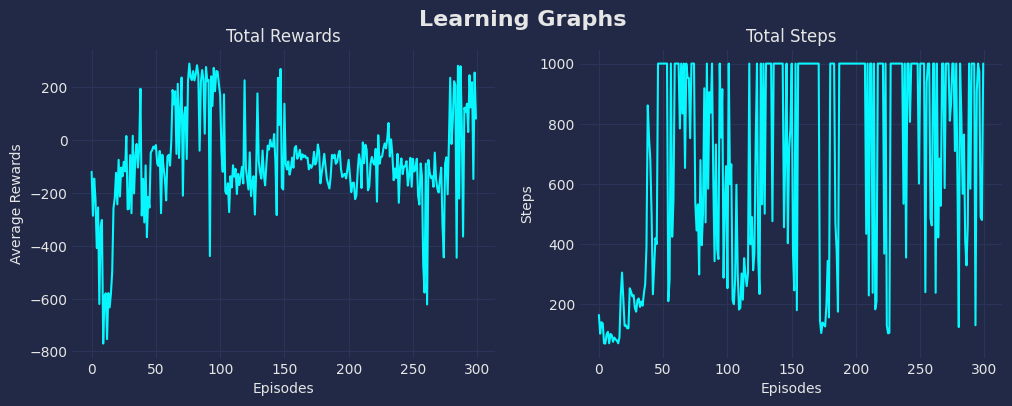

In [52]:
ddpg_lander_agent_gaussian.plot()

#### Observations

Make observations

### Problem 2: Bandit Algorithms

#### (a) Bandit Environment

In [53]:
class Arm:
    '''Returns a reward r_t sampled from N(mu, sigma) every time it is pulled.'''
    def __init__(self, mu: float, sigma: float = 1.0):
        self.mu = mu
        self.sigma = sigma
        
    def pull(self) -> float:
        return np.random.normal(self.mu, self.sigma)
    
class BanditsEnv:
    '''Contains K bandit arms and returns the reward of the arm pulled.'''
    def __init__(self, K: int, means: list):
        assert len(means) == K, 'Number of means should be equal to K'
        self.K = K
        self.arms = [Arm(mu) for mu in means]
        
    def reward(self, action: int) -> float:
        return self.arms[action].pull()
    
    def optimal_value(self) -> float:
        return max([arm.mu for arm in self.arms])

#### (b) Greedy, Eps-greedy, Eps-greedy with decay, and UCB Algorithms 

In [54]:
class Agent:
    '''Agent tries to minimize regret using different strategies.'''
    def __init__(self, env: BanditsEnv):
        self.env = env
        self.K = env.K
        self.Q_estimates = np.zeros(self.K)
        self.action_counts = np.zeros(self.K)

    def reset(self):
        self.Q_estimates = np.zeros(self.K)
        self.action_counts = np.zeros(self.K)
        
    def update_Q(self, action: int, reward: float):
        self.action_counts[action] += 1
        self.Q_estimates[action] += (1/self.action_counts[action]) * (reward - self.Q_estimates[action])
        
    def random_best_action(self, values: np.ndarray) -> int:
        return np.random.choice(np.argwhere(values == values.max()).flatten())
    
    def ucb_scores(self, t: int) -> np.ndarray:
        return self.Q_estimates + np.sqrt(2 * np.log(t)/self.action_counts)
        
    def run_greedy(self, N: int, M: int):
        return self.run_decay_epsilon_greedy(N, M, epsilon=0.0, decay=0.0)
        
    def run_epsilon_greedy(self, N: int, M: int, epsilon: float):
        return self.run_decay_epsilon_greedy(N, M, epsilon, decay=0.0)
        
    def run_decay_epsilon_greedy(self, N: int, M: int, epsilon: float, decay: float):
        self.reset()
        rewards = []
        # Initial exploration
        for i in range(M):
            for a in range(self.K):
                r_a = self.env.reward(a)
                self.update_Q(a, r_a)                
                rewards.append(r_a)
        
        # Exploitation
        for t in range(M*self.K, N):
            if np.random.random() < epsilon:
                a = np.random.choice(self.K) # Exploration
            else:
                a = self.random_best_action(self.Q_estimates) # Exploitation
                
            r_a = self.env.reward(a)
            self.update_Q(a, r_a)
            rewards.append(r_a)
            
            epsilon *= (1 - decay) # Epsilon decay
            
        return np.array(rewards), self.action_counts        
    
    def run_UCB(self, N: int):
        self.reset()
        rewards = []
        
        # Initial exploration
        for a in range(self.K):
            r_a = self.env.reward(a)
            self.update_Q(a, r_a)                
            rewards.append(r_a)
        
        # Exploitation
        for t in range(self.K, N):
            a = self.random_best_action(self.ucb_scores(t))
            r_a = self.env.reward(a)
            self.update_Q(a, r_a)
            rewards.append(r_a)
            
        return np.array(rewards), self.action_counts

#### Run the different algorithms

In [55]:
def run_algos(agent: Agent, N: int=1000, num_episodes: int=100):
    algos = ['Greedy', '$\epsilon$-Greedy ($\epsilon=0.1$)', '$\epsilon$-Greedy ($\epsilon=0.01$)', '$\epsilon$-Greedy with decay ($\epsilon=1, r=0.99$)', 'UCB']
    M = int(0.002 * N) # Initial exploration
    avg_rewards = np.zeros((len(algos), N))
    avg_cnts = np.zeros((len(algos), agent.K))
    
    for i in range(num_episodes):
        rewards, cnts = agent.run_greedy(N, M)
        avg_rewards[0] += rewards
        avg_cnts[0] += cnts
        
        rewards, cnts = agent.run_epsilon_greedy(N, M, 0.01)
        avg_rewards[1] += rewards
        avg_cnts[1] += cnts
        
        rewards, cnts = agent.run_epsilon_greedy(N, M, 0.1)
        avg_rewards[2] += rewards
        avg_cnts[2] += cnts
        
        rewards, cnts = agent.run_decay_epsilon_greedy(N, M, 1, 0.01)
        avg_rewards[3] += rewards
        avg_cnts[3] += cnts
        
        rewards, cnts = agent.run_UCB(N)
        avg_rewards[4] += rewards
        avg_cnts[4] += cnts
    
    avg_rewards /= num_episodes
    avg_cnts /= num_episodes
    avg_regrets = agent.env.optimal_value() - avg_rewards
    
    return avg_rewards, avg_regrets, avg_cnts, algos

In [56]:
K = 10
arm_means = [3, 1, 4, 10, 5, 9, 2, 6, 7, 8]
bandits = BanditsEnv(K, arm_means)
agent = Agent(bandits)

N = 1000
avg_rewards_5, avg_regrets_5, avg_cnts_5, algos = run_algos(agent, N, num_episodes=5)
avg_rewards_1000, avg_regrets_1000, avg_cnts_1000, _ = run_algos(agent, N, num_episodes=1000)

#### (c) Average Reward vs Rounds

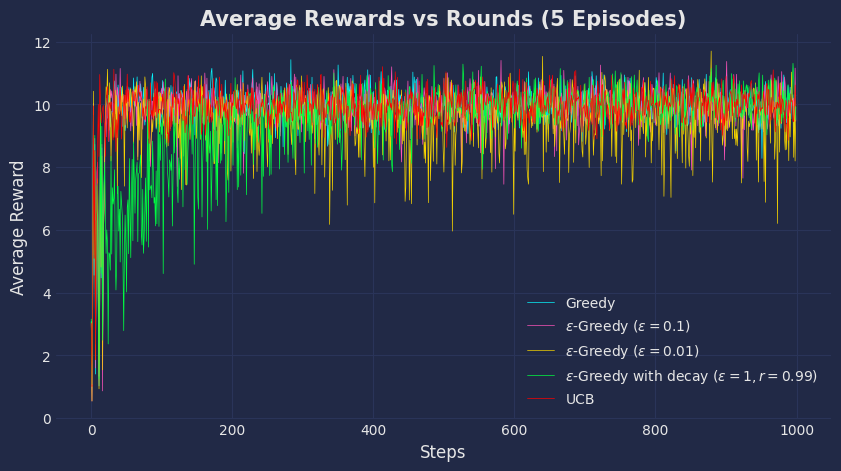

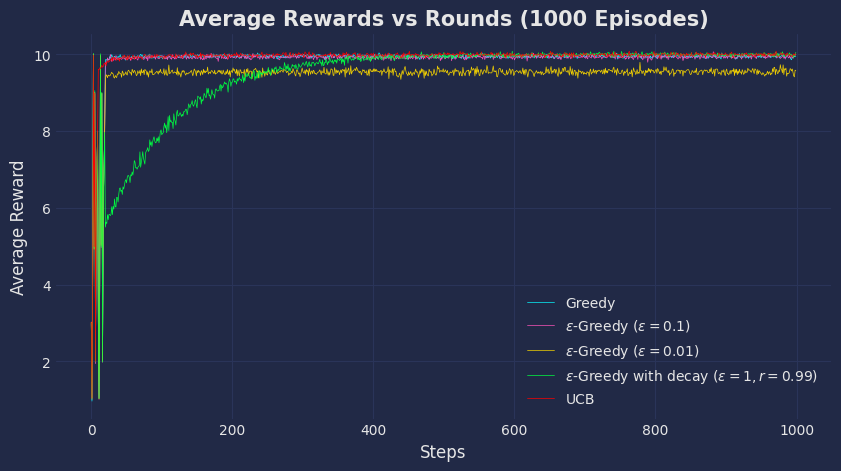

In [57]:
def plot_avg_rewards(avg_rewards: np.ndarray, algos: list, N: int, title: str = 'Average Rewards vs Rounds'):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=15, fontweight='bold')
    for i in range(len(algos)):
        plt.plot(np.arange(N), avg_rewards[i], label=algos[i], lw=0.5)
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.legend()
    plt.show()
    
plot_avg_rewards(avg_rewards_5, algos, N, title='Average Rewards vs Rounds (5 Episodes)')
plot_avg_rewards(avg_rewards_1000, algos, N, title='Average Rewards vs Rounds (1000 Episodes)')

#### (d) Average Arm Pulls

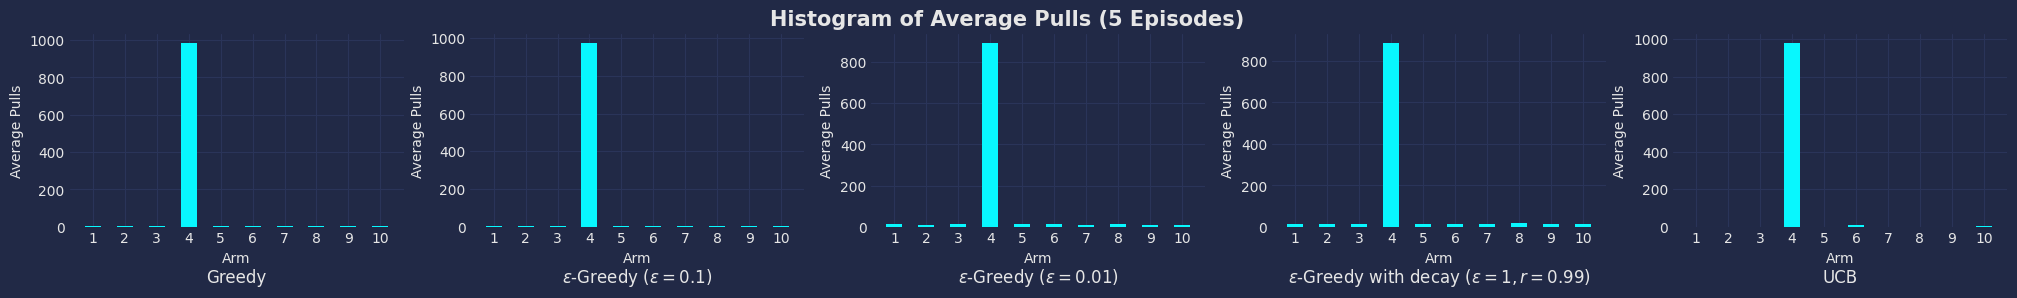

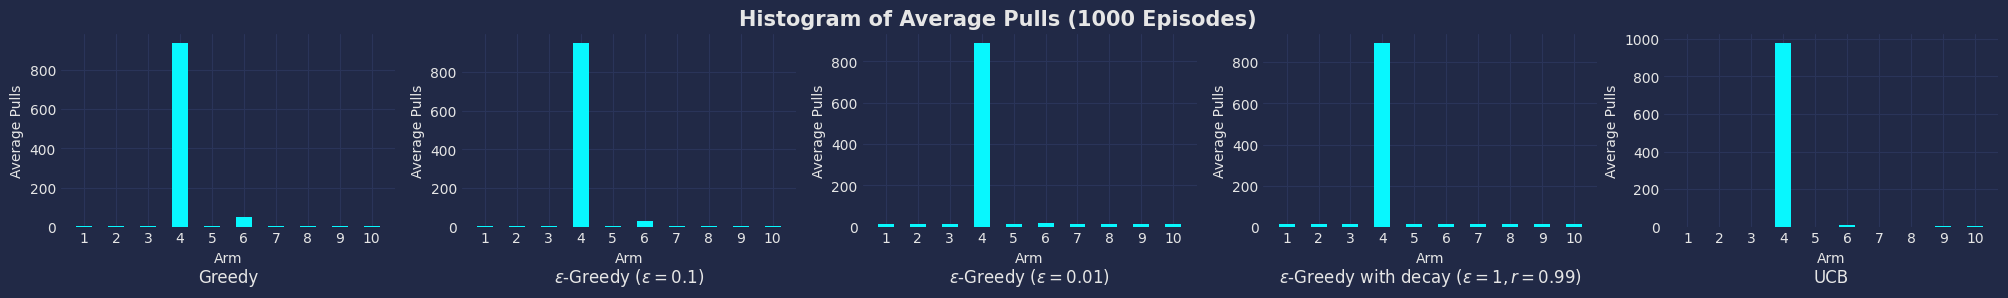

In [58]:
def plot_hist_cnts(avg_cnts: np.ndarray, algos: list, title: str = 'Histogram of Average Pulls', log_scale: bool = False):
    K = avg_cnts.shape[1]
    plt.figure(figsize=(5*len(algos), 2.5))
    plt.suptitle(title, fontsize=15, fontweight='bold')
    for i, algo in enumerate(algos):
        plt.subplot(1, len(algos), i+1)
        plt.bar(np.arange(1, K+1), avg_cnts[i], width=0.5)
        plt.title(algo, fontsize=12, y=-0.33)
        plt.xticks(np.arange(1, K+1))
        plt.xlabel('Arm', fontsize=10)
        plt.ylabel('Average Pulls', fontsize=10)
        plt.yscale('log' if log_scale else 'linear')
    plt.show()
    
plot_hist_cnts(avg_cnts_5, algos, title='Histogram of Average Pulls (5 Episodes)', log_scale=False)
plot_hist_cnts(avg_cnts_1000, algos, title='Histogram of Average Pulls (1000 Episodes)', log_scale=False)

#### (e) Average Regret vs Time

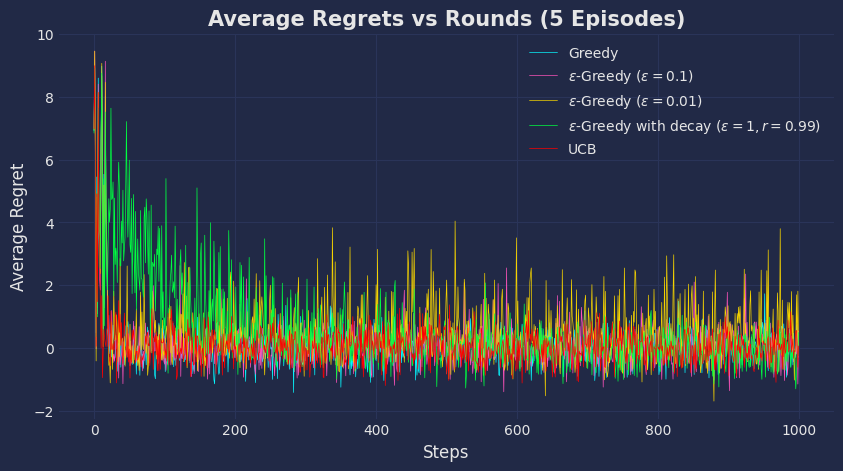

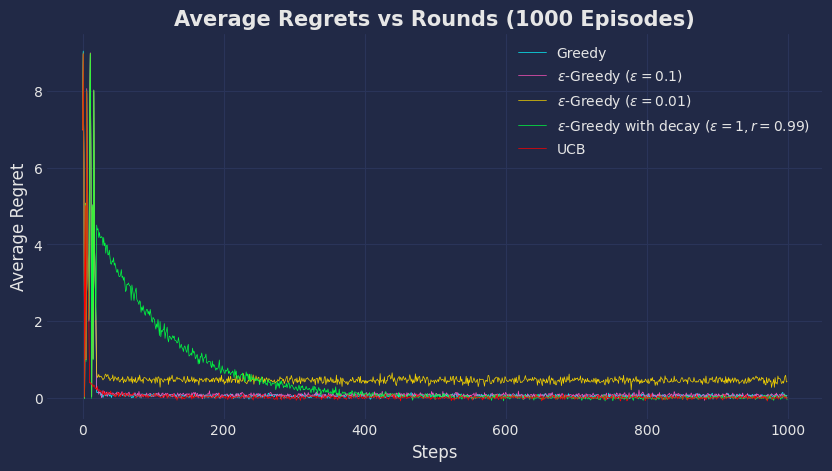

In [59]:
def plot_avg_regrets(avg_regrets: np.ndarray, algos: list, N: int, title: str = 'Average Regrets vs Rounds'):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=15, fontweight='bold')
    for i in range(len(algos)):
        plt.plot(np.arange(N), avg_regrets[i], label=algos[i], lw=0.5)
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('Average Regret', fontsize=12)
    plt.legend()
    plt.show()
    
plot_avg_regrets(avg_regrets_5, algos, N, title='Average Regrets vs Rounds (5 Episodes)')
plot_avg_regrets(avg_regrets_1000, algos, N, title='Average Regrets vs Rounds (1000 Episodes)')

#### (f) Comparison of Algorithms

In [60]:
# Print the total regrets for each algorithm
print('Total Average Regrets:')
for i in range(len(algos)):
    display(Markdown(f'{np.sum(avg_regrets_1000[i]):.2f} -> **{algos[i]}**'))

# Print the total pulls for each algorithm
algos_raw = ['Greedy', 'eps-Greedy (eps=0.1)', 'eps-Greedy (eps=0.01)', 'eps-Greedy with decay (eps=1, r=0.99)', 'UCB']
print('\nTotal Average Pulls:')
pandas.DataFrame(avg_cnts_1000, columns=[f'Arm {i+1}' for i in range(K)], index=algos_raw)

Total Average Regrets:


137.91 -> **Greedy**

159.99 -> **$\epsilon$-Greedy ($\epsilon=0.1$)**

539.11 -> **$\epsilon$-Greedy ($\epsilon=0.01$)**

540.60 -> **$\epsilon$-Greedy with decay ($\epsilon=1, r=0.99$)**

66.41 -> **UCB**


Total Average Pulls:


,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
Greedy,2.000,2.000,2.000,934.473,2.000,49.485,2.000,2.000,2.005,2.037
eps-Greedy (eps=0.1),2.946,2.957,2.941,946.523,2.966,29.608,2.978,3.009,3.051,3.021
eps-Greedy (eps=0.01),11.893,11.747,11.856,886.521,11.627,18.968,11.748,11.848,11.917,11.875
"eps-Greedy with decay (eps=1, r=0.99)",12.004,12.081,12.003,890.978,11.963,12.992,12.044,11.943,12.004,11.988
UCB,1.000,1.000,1.005,975.652,1.083,12.086,1.000,1.350,1.999,3.825


Hence we see that UCB has the least regret and the most average reward. Hence its the best algorithm.

#### (g) Scenario: Second best arm and the best arm are close

In [61]:
K = 10
means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.97, 0.98, 1.02, 0.97]
bandits = BanditsEnv(K, means)
agent = Agent(bandits)

N = 1000
avg_rewards_5, avg_regrets_5, avg_cnts_5, algos = run_algos(agent, N, num_episodes=5)
avg_rewards_1000, avg_regrets_1000, avg_cnts_1000, _ = run_algos(agent, N, num_episodes=1000)

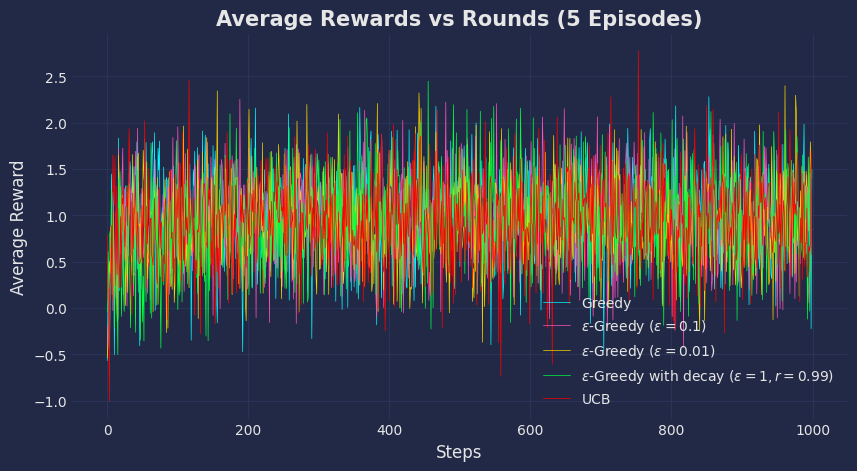

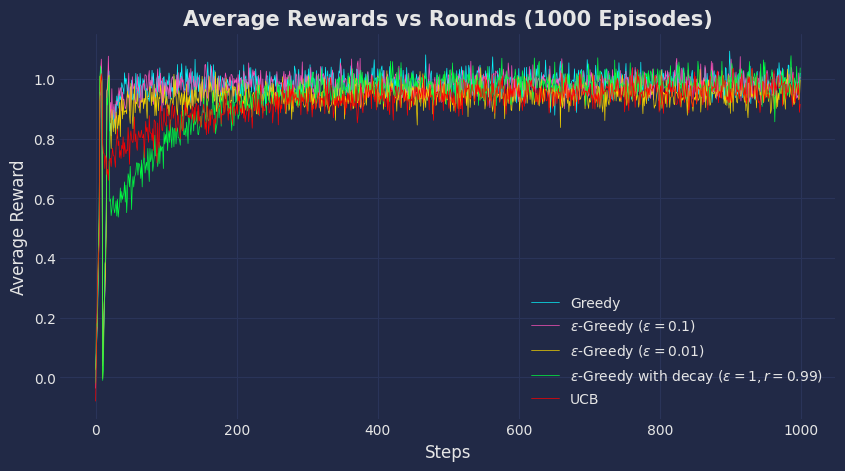

In [62]:
plot_avg_rewards(avg_rewards_5, algos, N, title='Average Rewards vs Rounds (5 Episodes)')
plot_avg_rewards(avg_rewards_1000, algos, N, title='Average Rewards vs Rounds (1000 Episodes)')

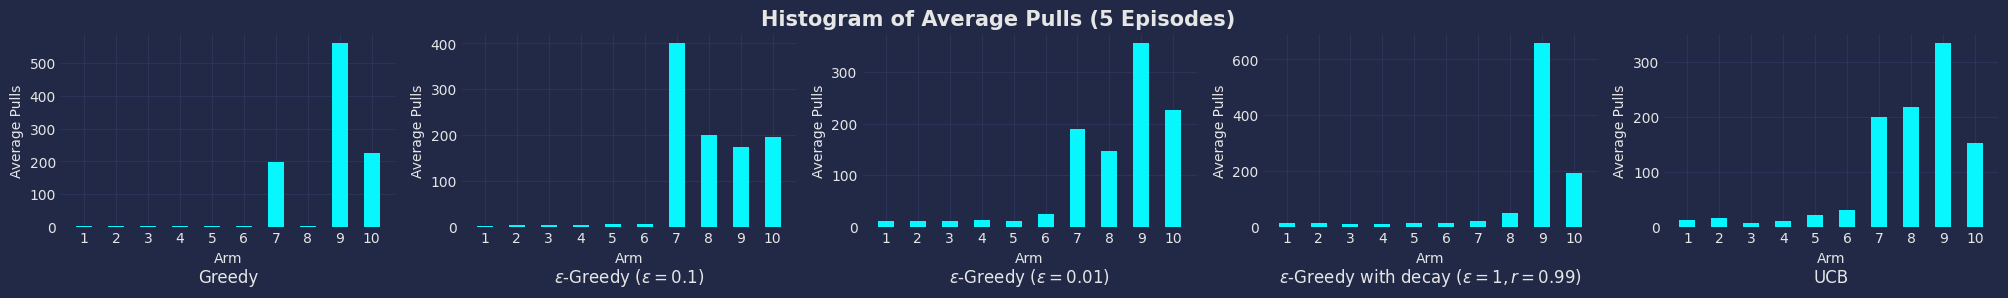

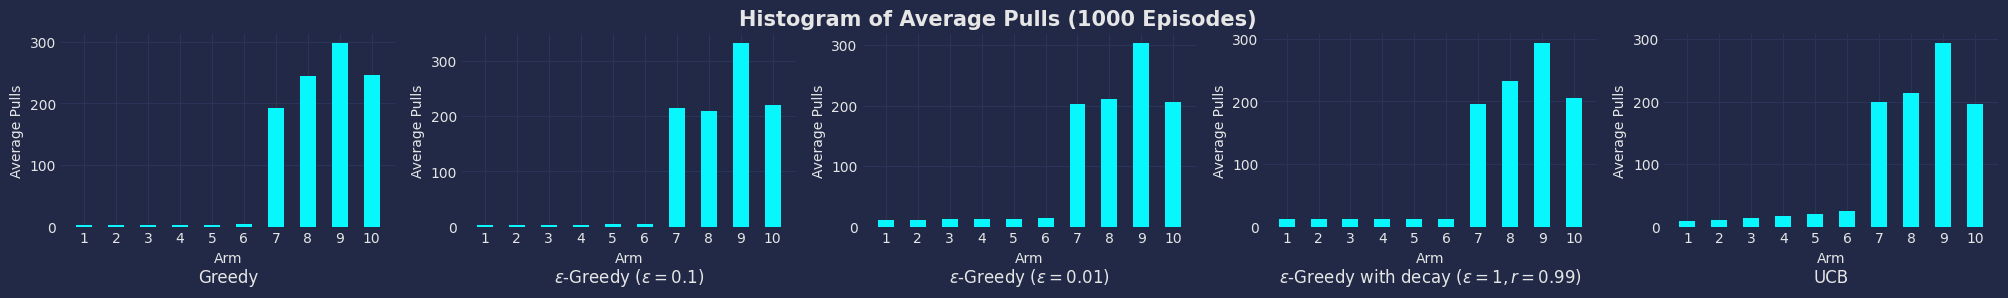

In [63]:
plot_hist_cnts(avg_cnts_5, algos, title='Histogram of Average Pulls (5 Episodes)', log_scale=False)
plot_hist_cnts(avg_cnts_1000, algos, title='Histogram of Average Pulls (1000 Episodes)', log_scale=False)

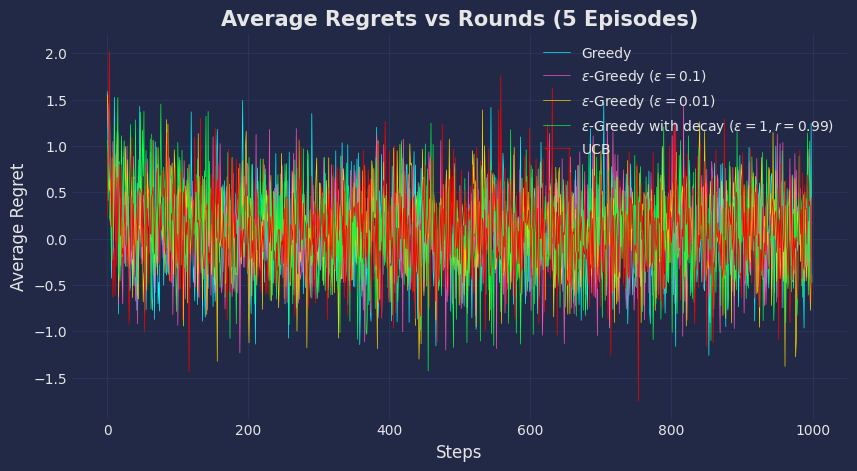

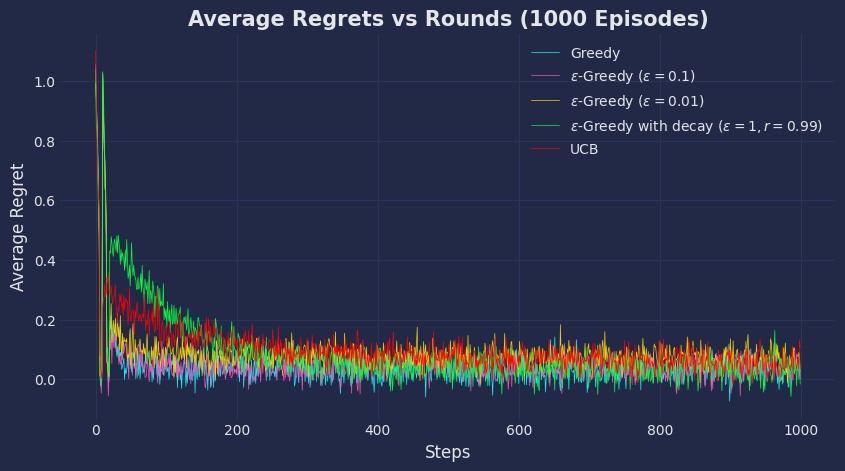

In [64]:
plot_avg_regrets(avg_regrets_5, algos, N, title='Average Regrets vs Rounds (5 Episodes)')
plot_avg_regrets(avg_regrets_1000, algos, N, title='Average Regrets vs Rounds (1000 Episodes)')

In [65]:
# Print the total regrets for each algorithm
print('Total Average Regrets:')
for i in range(len(algos)):
    display(Markdown(f'{np.sum(avg_regrets_1000[i]):.2f} -> **{algos[i]}**'))
    
# Print the total pulls for each algorithm
print('\nTotal Average Pulls:')
pandas.DataFrame(avg_cnts_1000, columns=[f'Arm {i+1}' for i in range(K)], index=algos_raw)

Total Average Regrets:


45.19 -> **Greedy**

47.54 -> **$\epsilon$-Greedy ($\epsilon=0.1$)**

85.59 -> **$\epsilon$-Greedy ($\epsilon=0.01$)**

86.09 -> **$\epsilon$-Greedy with decay ($\epsilon=1, r=0.99$)**

97.82 -> **UCB**


Total Average Pulls:


,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
Greedy,2.277,3.399,2.489,2.691,3.706,4.377,193.204,245.103,297.154,245.600
eps-Greedy (eps=0.1),3.242,3.455,3.486,3.955,4.728,5.505,214.984,208.626,331.142,220.877
eps-Greedy (eps=0.01),11.955,11.955,12.282,12.669,13.431,14.591,202.505,211.033,302.787,206.792
"eps-Greedy with decay (eps=1, r=0.99)",12.148,11.961,12.078,12.198,12.326,12.859,196.097,233.067,292.481,204.785
UCB,9.586,11.373,13.770,17.182,20.640,25.635,198.940,212.986,292.908,196.980
